In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'predict')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
# pth_out = os.path.join(pth, 'figures', 'cancer', 'CCCA')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
for mod in ('Early', 'Late'):
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    g = pd.read_csv(fn).mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = mod,
                          random_state = 1234)
        adata.obs.loc[msk, mod] = adata_group.obs[mod]

Early
Late


In [84]:
#
cols = ['Early', 'Late']
X = adata.obs[cols].values
adata.obsm['X_mod'] = X

#
src_traj = ('GSE162534', 'GSE229103', 'rRNAModifications')
msk_traj = adata.obs.source.isin(src_traj)
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')
msk_pca = msk_traj & (msk_train | msk_val)
X0 = (adata.obsm['X_mod'][:, 0] -
      adata.obsm['X_mod'][:, 1])
X1 = adata.obs.latent_z.values
adata.obsm['X_mod_pca'] = np.concatenate(
    (X0.reshape(-1, 1), X1.reshape(-1, 1)), axis = 1)

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


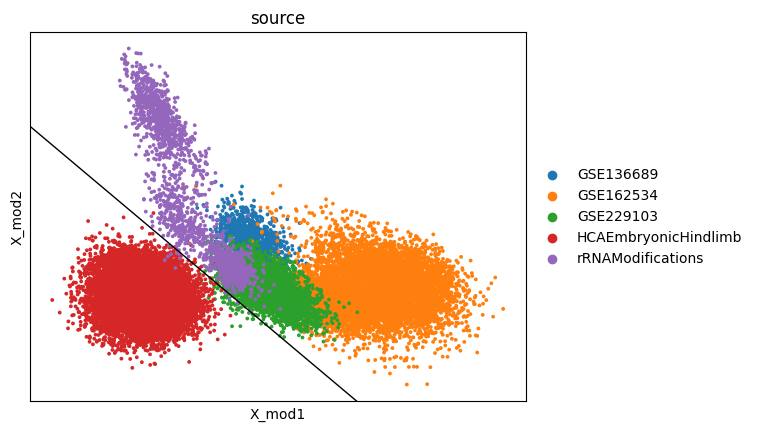

In [85]:
sc.pl.embedding(adata[msk_train | msk_val], 'X_mod',
                size = 30, show = False, color = 'source')
# plt.axvline(0, c = 'k', lw = 1)
# plt.axhline(0, c = 'k', lw = 1)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([-100, 100], [100, -100], c = 'k', lw = 1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

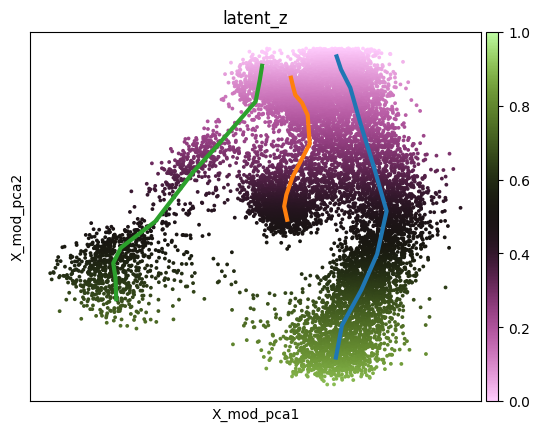

In [89]:
sc.pl.embedding(adata[msk_pca], 'X_mod_pca', show = False,
                size = 30, color = 'latent_z',
                vmin = 0, vmax = 1, cmap = 'vanimo')

cols = ['X_mod_pca1', 'X_mod_pca2']
adata.obs[cols] = adata.obsm['X_mod_pca'][:, :2]
for i, (src, df) in enumerate(adata[msk_pca].obs.groupby('source', observed = True)):
    z_bin = pd.qcut(df.latent_z, 10)
    df['latent_z_bin'] = z_bin
    df_plt = df.groupby('latent_z_bin', observed = True)[cols].mean()
    plt.plot(df_plt.X_mod_pca1, df_plt.X_mod_pca2, lw = 3)


plt.gca().invert_yaxis()
plt.show()